# Visualising our approach to tuning Ridge Regression

This notebook serves the purpose of presenting our key findings while tuning our ridge regression's parameters and showing how we set out to find these parameters, namely determining the lambda used for regularization and the degrees to which we augment our data. Further, we decide to illustrate why we decided to prioritise lower misclassification in determining these parameters than mean squared error, and reinforce what was taught to us, that the mean squared error can mislead if blindly trusted in classification problems.

In [1]:
import numpy as np
from helpers import build_poly, build_k_indices, fill_nan_closure, minmax_normalize_closure,\
standardize_closure, predict_without_classifying, batch_iter
from proj1_helpers import load_csv_data, predict_labels
from implementations import compute_mse, ridge_regression 
import matplotlib.pyplot as plt

DATA_PATH = '../data/'
PLOT_OUTPUT_PATH = '../plots/'
seed = 12

# We work with the training data in this notebook
y, x, ids = load_csv_data(DATA_PATH+'train.csv')

# Fill all NA values (-999 in this case) with the median of each column - will compare later median vs mean but not now
x, _ = fill_nan_closure(x, np.nanmedian)

# Minmax normalization of x matrix - will compare minmax vs standardization later in this notebook but not now
minmax_normalize = minmax_normalize_closure(np.min(x, axis=0), np.max(x, axis=0))
x = minmax_normalize(x)

In [5]:
lambda_ = np.array([0]) # Removed regularization for illustrative purpose of why we preferred minimizing misclassification over mse
degrees = np.arange(1,7) 
k_fold = 7

def cross_validation(y, x, k_indices, k, lambda_, degree):
    
    # Current fold test indices are our k indices, all non-k indices are our train indices
    te_indice, tr_indice = k_indices[k], k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    # Split data according to determined indices
    y_te, y_tr = y[te_indice], y[tr_indice]
    x_te, x_tr = x[te_indice], x[tr_indice]
    
    # Build tildeX (including offset term) and augment to provided degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    # Compute optimal weights using normal form solution
    w, _ = ridge_regression(y_tr, tx_tr, lambda_)
    
    # Calculate fold MSE for training and test partitions
    mse_tr = compute_mse(y_tr, tx_tr, w)
    mse_te = compute_mse(y_te, tx_te, w)
    
    # Calculate fold misclassification % (ratio of how many inaccurate predictions were made)
    y_tr_pred = predict_labels(w, tx_tr)
    y_te_pred = predict_labels(w, tx_te) # we store the predictions on test to show what may drive mse losses in each degree 

    misclass_tr = sum(y_tr_pred != y_tr)/len(y_tr)
    misclass_te = sum(y_te_pred != y_te)/len(y_te)
    
    y_te_pred_pre_classification = predict_without_classifying(w, tx_te)
    
    return mse_tr, mse_te, misclass_tr, misclass_te, y_te_pred_pre_classification, w

def compare_mse_misclassification_tuning():
   
    # build fold indices to feed into cross validation
    k_indices = build_k_indices(y, k_fold, seed)

    # initiate empty lists to store average (over the folds) mse on training and test and average
    # misclassification on training on test 
    
    mse_te, mse_tr = [], []
    acc_te, acc_tr = [], []
    y_pred_te = []
    
    for deg in degrees:
        print(f'Computing for Degree {deg}')
        
        # store mses and misclassification for each fold
        mse_te_tmp, mse_tr_tmp = [], []
        acc_te_tmp, acc_tr_tmp = [], []
        y_pred_te_tmp = np.array([]) 
            
        for k in range(k_fold):

            fold_mse_tr, fold_mse_te, fold_acc_tr, fold_acc_te, y_te_fold_pred , _ = cross_validation(y, x, k_indices, k, lambda_, deg)

            # store mse, misclassification accuracy and predictions made of fold for logging
            mse_te_tmp.append(fold_mse_te) ; mse_tr_tmp.append(fold_mse_tr)
            acc_te_tmp.append(fold_acc_te) ; acc_tr_tmp.append(fold_acc_tr)
            y_pred_te_tmp = np.hstack((y_pred_te_tmp, y_te_fold_pred))

        # average the folds and store for logging    
        mse_te.append(np.mean(mse_te_tmp, axis=0)) ; mse_tr.append(np.mean(mse_tr_tmp, axis=0))
        acc_te.append(np.mean(acc_te_tmp, axis=0)) ; acc_tr.append(np.mean(acc_tr_tmp, axis=0))
        y_pred_te.append(y_pred_te_tmp)
        
    best_d_mse = degrees[np.argmin(mse_te)]
    best_d_misclass = degrees[np.argmin(acc_te)]

    # We recognize we selected the "best" values for each degree according to MSE (instead of misclassification %) but it still shows why MSE is flawed
    print(f'According to the lowest MSE the best degree was {best_d_mse}, while according to the lowest misclassifications it was {best_d_misclass}')
    
    return mse_te, mse_tr, acc_te, acc_tr, y_pred_te

mse_te, mse_tr, acc_te, acc_tr, y_pr = compare_mse_misclassification_tuning()

Computing for Degree 1
Computing for Degree 2
Computing for Degree 3
Computing for Degree 4
Computing for Degree 5
According to the lowest MSE the best degree was 1, while according to the lowest misclassifications it was 5


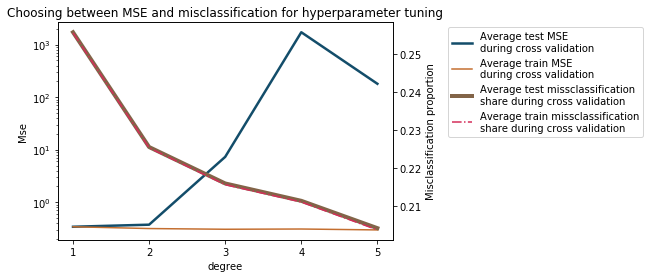

In [57]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,4))

lns1 = ax.plot(degrees, mse_te, color='#134d6a', linewidth=2.5, label='Average test MSE\nduring cross validation')
lns2 = ax.plot(degrees, mse_tr, color='#c46e2f', label='Average train MSE\nduring cross validation')

ax2=ax.twinx()

lns3 = ax2.plot(degrees, acc_te, color='#826448', linewidth=4,label='Average test missclassification\nshare during cross validation')
lns4 = ax2.plot(degrees, acc_tr, color='#d42e59', linestyle='dashdot', label='Average train missclassification\nshare during cross validation')

ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Mse')
ax.set_xticks(degrees)
ax2.set_ylabel('Misclassification proportion')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.15, 1))

plt.title('Choosing between MSE and misclassification\nfor hyperparameter tuning\n')
plt.show()

Interesting, we observe that the MSE of the test folds of cross validation observe higher MSEs in higher degrees. We illustrate why this happens in the following graph. Specifically, we observe that the model predicts due to the polynomial augmented data some very distant prediction values of y (reminder that y obtains values -1 and 1), thus heavily influencing the MSE defined by $\frac{1}{2N}\sum_{n=1}^N (y-y_{pred})^2$. Thus conceptually the notion of distance does not make sense in our classification problem and we decide to choose our hyperparameters instead based on those hyperparameters which are accompanied by the lowest testing error. Note that we have included both the training and the test averages of both loss methods during the k-fold cross validation from which we observe overfitting should we blindly observe the MSE and forget our initial classification problem. This further influenced our decision to pick hyperparameters by the lowest class inaccuracy instead of MSE.

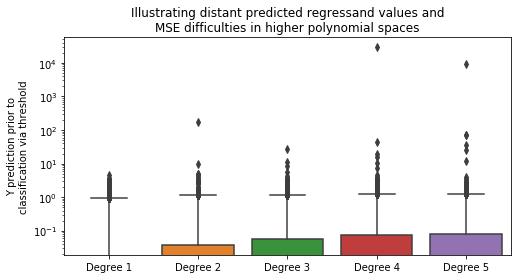

In [83]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=[lst.tolist() for lst in y_pr])
ax.set_xticklabels(['Degree '+str(d) for d in degrees])

ax.set_yscale('log')
ax.set_ylabel('Y prediction prior to\nclassification via threshold')

plt.title('Illustrating distant predicted regressand values and\nMSE difficulties in higher polynomial spaces')
plt.show()

fig.savefig(PLOT_OUTPUT_PATH+"Distant regressand values.pdf", bbox_inches='tight')